In [161]:
# Lectura del conjunto de datos utilizando Pandas
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import chi2_contingency # Test de independencia

dolar = pd.read_csv('dolarMEP.csv')
df = pd.read_csv('lista_prestamos.csv')
df

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia
...,...,...,...,...,...,...,...,...,...
401,10/01/2018,Decoracion,45,21600,Buenos Aires,F,48,48,+180 dias
402,09/01/2018,Otros destinos,36,14000,Santa Fe,D,48,48,+180 dias
403,04/01/2018,Refaccion y construccion de vivienda,50,30000,Buenos Aires,E,48,48,+180 dias
404,04/01/2018,Refaccion y construccion de vivienda,35,32355,Ciudad de Buenos Aires,D,48,48,+180 dias


In [162]:
# Realizamos una copia del original para no trabajar sobre esta
df_orig= df.copy()
df.head()

,Fecha,Destino,Edad,Ingresos,Zona geografica,Perfil,Plazo,Cuota,class
0,22/03/2024,Refaccion y construccion de vivienda,45,2000000,Buenos Aires,A,6,1,Al dia
1,18/03/2024,Decoracion,40,5000000,La Pampa,AA,6,1,Al dia
2,21/02/2024,Refaccion y construccion de vivienda,52,935000,Rio Negro,AA,18,1,Al dia
3,19/02/2024,Viaje,70,450000,Corrientes,AA,18,1,Al dia
4,06/02/2024,Refaccion y construccion de vivienda,57,326000,Buenos Aires,C,6,1,Al dia


In [163]:
# vemos que tipo de datos tiene el data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            406 non-null    object
 1   Destino          406 non-null    object
 2   Edad             406 non-null    int64 
 3   Ingresos         406 non-null    int64 
 4   Zona geografica  406 non-null    object
 5   Perfil           406 non-null    object
 6   Plazo            406 non-null    int64 
 7   Cuota            406 non-null    int64 
 8   class            406 non-null    object
dtypes: int64(4), object(5)
memory usage: 28.7+ KB


In [164]:
# Al analizar la base de datos, tendremos que hacer varias modificaciones para representarlo correctamente 
# para ingresos lo pasaremos a dolares utilizando una base de dato donde tenemos según meses el valor máximo de valor mep
# con respecto a la cuota lo dividiremos por el plazo para tener un porcentaje de avance de los pagos 
# con respecto a clases dividiremos en los que son "Al dia" -> "1" y todos los demas como "0"
# cuando ingresemos una nueva entrada lo pasaremos por esta función 

dolar_prueba = dolar.copy()
df_prueba1= df.copy()



def editor_fichero(fichero,fichero_dolar):

    def convertir_etiqueta(fichero): #empezamos por class
        fichero.loc[fichero['class'] == 'Al dia', 'class'] = 1
        fichero.loc[fichero['class'] != 1, 'class'] = 0        
        return fichero
    

    #def convertir_cuota_en_porcentaje(fichero): #modificamos las cuotas por un porcentaje de avance del cuota/plazo
    #    fichero['porcentaje_Avance'] = fichero['Cuota']/fichero['Plazo']
    #    del fichero['Cuota']
    #    return fichero
    
    def pasar_ingresos_a_dolares(fichero, fichero_dolar):  #pasar a dolares los ingresos - sacamos el mayor dolar de cada mes y ese será el valor a convertir
       
        #transformamos las columnas de fecha a variable datetime
        fichero['Fecha'] = pd.to_datetime(fichero['Fecha'], dayfirst=True, errors='ignore')
        fichero_dolar['Fecha'] =pd.to_datetime(fichero_dolar['Fecha'], dayfirst=True, errors='ignore')

        #creamos una nueva columna del dolar para esa fecha en particular, luego los ingresos se dividiran por este dolar
        fichero['dolar']=""
        fichero['ingresos en dolares']=""

        for x in range(0,(len(fichero.index)),1):
            cond=False
            cont=0
            dia=pd.to_timedelta('1 days')


            while cond==False:
                cont=cont+1
                for y in range(0,(len(fichero_dolar.index)),1):
                    if (fichero.loc[(x,'Fecha')]+dia*cont)==fichero_dolar.loc[(y,'Fecha')]:
                        fichero.loc[(x,'dolar')] = fichero_dolar.loc[(y,'dolar')]
                        cond=True
                        break  

        fichero['ingresos en dolares'] = (fichero['Ingresos'] / fichero['dolar']).astype('float64')
        
        del fichero['Ingresos']
        del fichero['Fecha']
        del fichero['dolar']
        del fichero['Cuota']

        return fichero
        fichero['class']=fichero['class'].astype(int)
    return pasar_ingresos_a_dolares(convertir_etiqueta(fichero),fichero_dolar)


editor_fichero(df_prueba1, dolar_prueba)





,Destino,Edad,Zona geografica,Perfil,Plazo,class,ingresos en dolares
0,Refaccion y construccion de vivienda,45,Buenos Aires,A,6,1,1974.450609
1,Decoracion,40,La Pampa,AA,6,1,4843.271727
2,Refaccion y construccion de vivienda,52,Rio Negro,AA,18,1,886.440774
3,Viaje,70,Corrientes,AA,18,1,416.547102
4,Refaccion y construccion de vivienda,57,Buenos Aires,C,6,1,271.800302
...,...,...,...,...,...,...,...
401,Decoracion,45,Buenos Aires,F,48,0,1066.140178
402,Otros destinos,36,Santa Fe,D,48,0,691.016782
403,Refaccion y construccion de vivienda,50,Buenos Aires,E,48,0,1480.750247
404,Refaccion y construccion de vivienda,35,Ciudad de Buenos Aires,D,48,0,1596.989141


In [165]:
df_prueba=df_prueba1.copy()

In [166]:
import matplotlib.pyplot as plt
df_prueba['class']=df_prueba['class'].astype(int)
# Creamos las variables dummies (binarias)
dummies = pd.get_dummies(df_prueba,columns=['Destino'], drop_first=False, dtype=int)
df_prueba[dummies.columns] = dummies
dummies2 = pd.get_dummies(df_prueba,columns=['Perfil'], drop_first=False, dtype=int)
df_prueba[dummies2.columns] = dummies2
dummies3 = pd.get_dummies(df_prueba,columns=['Zona geografica'], drop_first=False, dtype=int)
df_prueba[dummies3.columns] = dummies3

df_prueba= df_prueba.drop("Destino", axis=1)
df_prueba= df_prueba.drop("Zona geografica", axis=1)

# 'drop_first=True' indica que elimine la binaria para la primera categoría, en este caso 'aloj_completo'
# 'dtype=int' las crea con valores 0 y 1, sino las genera como booleanas


Index(['Edad', 'Perfil', 'Plazo', 'class', 'ingresos en dolares',
       'Destino_Cambio de vehiculo', 'Destino_Celebracion',
       'Destino_Compra de equipamientos',
       'Destino_Compra de inventario o materias primas',
       'Destino_Consolidacion de deuda', 'Destino_Decoracion',
       'Destino_Educacion', 'Destino_Enlace y casamiento',
       'Destino_Gastos medicos', 'Destino_Inicio actividad independiente',
       'Destino_Inversion relacionadas a locales/oficinas', 'Destino_Mudanza',
       'Destino_Otros destinos',
       'Destino_Prestamos Verdes - Eficiencia Energetica',
       'Destino_Refaccion y construccion de vivienda', 'Destino_Viaje',
       'Perfil_A', 'Perfil_AA', 'Perfil_B', 'Perfil_C', 'Perfil_D', 'Perfil_E',
       'Perfil_F', 'Zona geografica_Buenos Aires', 'Zona geografica_Catamarca',
       'Zona geografica_Chaco', 'Zona geografica_Chubut',
       'Zona geografica_Ciudad de Buenos Aires', 'Zona geografica_Cordoba',
       'Zona geografica_Corrientes', 'Zon

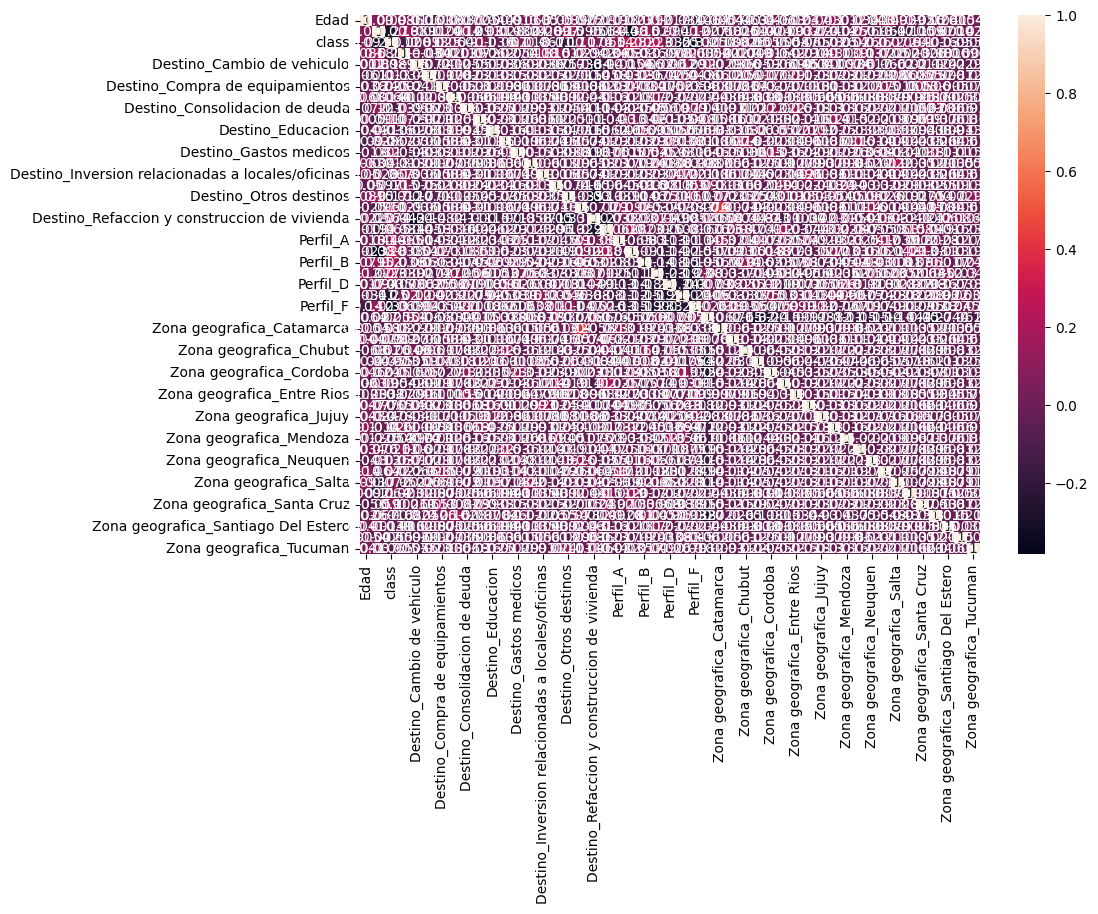

In [167]:
# Representar gráficamente la matriz de correlación 
plt.figure(figsize = (10,7))
sns.heatmap(df_prueba.select_dtypes(include='number').corr(), annot = True, cmap = "rocket")
print(df_prueba.columns)

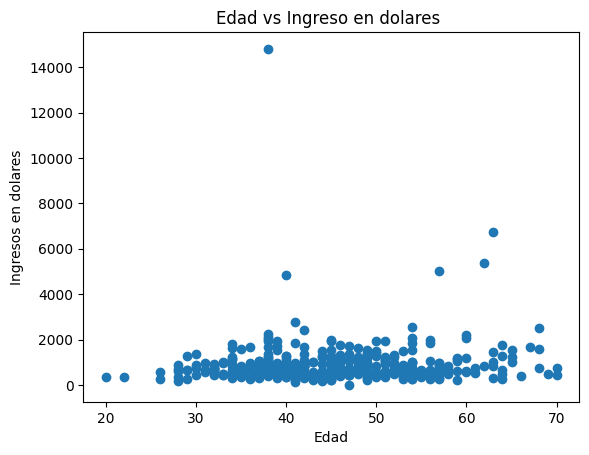

podemos ver que no existe una correlación fuerte entre edad e ingresos


In [168]:
plt.scatter(df_prueba['Edad'], df_prueba['ingresos en dolares'])
plt.title('Edad vs Ingreso en dolares ')
plt.xlabel('Edad')
plt.ylabel('Ingresos en dolares')
plt.show()
print("podemos ver que no existe una correlación fuerte entre edad e ingresos")

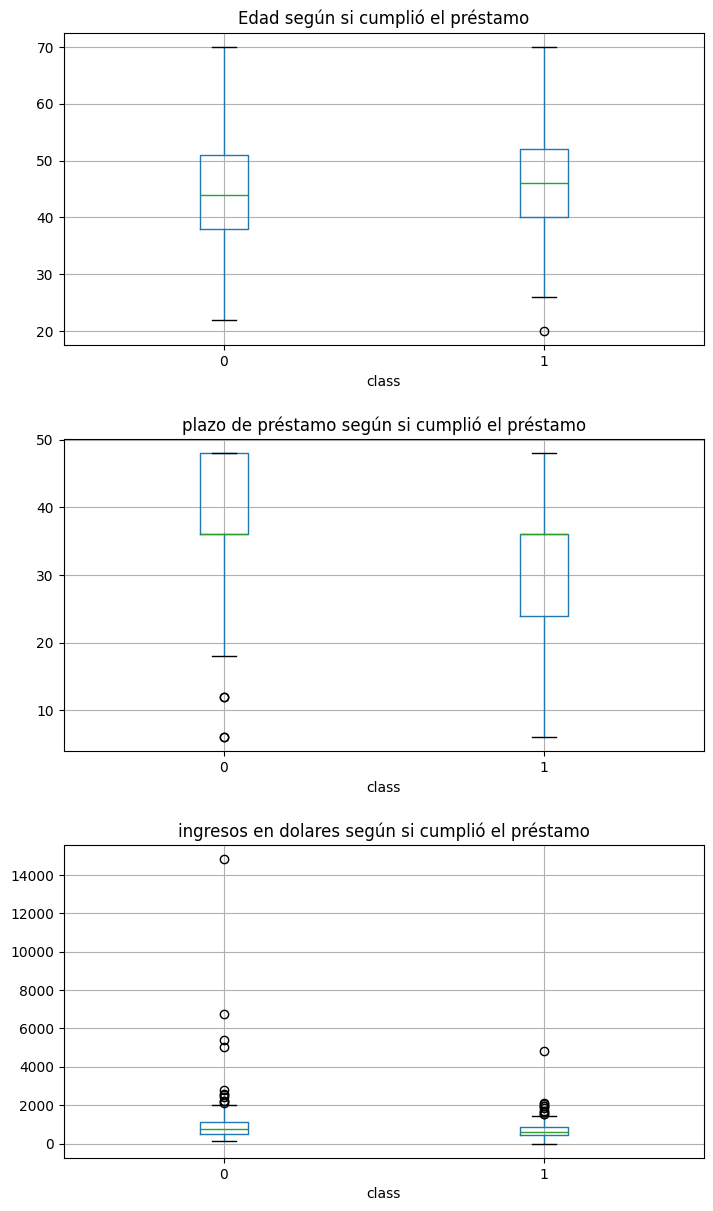

In [169]:
#realizamos un boxplot para las variables numéricas 
fig, ax = plt.subplots( 3, figsize=(8, 15))
# Edad
df_prueba.boxplot(column='Edad', by = 'class', ax=ax[0])
ax[0].set_title("Edad según si cumplió el préstamo")

# plazo de préstamo
df_prueba.boxplot(column='Plazo', by = 'class', ax=ax[1])
ax[1].set_title("plazo de préstamo según si cumplió el préstamo")

#ingresos en dolares a la hora de tomar el préstamo 
df_prueba.boxplot(column='ingresos en dolares', by = 'class', ax=ax[2])
ax[2].set_title("ingresos en dolares según si cumplió el préstamo")

fig.suptitle('')
plt.subplots_adjust(hspace=0.3)
plt.show()


In [170]:
#creamos para todas las variables una tabla de contingencia para datos categóricos 
cont=0
for i in df_prueba.columns:
    if i!= 'ingresos en dolares' and i!='Edad' and i!='Plazo' and i!='class':
        prueba_chi2 = chi2_contingency(pd.crosstab(df_prueba['class'],df_prueba[i]))
        if prueba_chi2[1].round(4) >0.1:
            cont+=1
            print(f"Estadístico chi2 de {i} vs class =  ", prueba_chi2[0].round(4))
            print(f"p-value de {i} vs class = ", prueba_chi2[1].round(4))
            print(f"los prestamos para {i} fueron de:")
            print(sum(df_prueba[i]==1))
            print("de estos prestamos se devolvieron a termino los siguientes:")
            print(sum(df_prueba[df_prueba[i]==1]["class"]))
            print(sum(df_prueba[df_prueba[i]==1]["class"])/sum(df_prueba[i]==1))
            print("--------------------*--------------------")
            
           
print(f"total de valores que no pasan el test Chi cuadrado es: {cont}")
           

Estadístico chi2 de Destino_Cambio de vehiculo vs class =   0.0012
p-value de Destino_Cambio de vehiculo vs class =  0.9721
los prestamos para Destino_Cambio de vehiculo fueron de:
59
de estos prestamos se devolvieron a termino los siguientes:
23
0.3898305084745763
--------------------*--------------------
Estadístico chi2 de Destino_Celebracion vs class =   0.0
p-value de Destino_Celebracion vs class =  1.0
los prestamos para Destino_Celebracion fueron de:
12
de estos prestamos se devolvieron a termino los siguientes:
5
0.4166666666666667
--------------------*--------------------
Estadístico chi2 de Destino_Compra de equipamientos vs class =   0.0
p-value de Destino_Compra de equipamientos vs class =  1.0
los prestamos para Destino_Compra de equipamientos fueron de:
4
de estos prestamos se devolvieron a termino los siguientes:
2
0.5
--------------------*--------------------
Estadístico chi2 de Destino_Compra de inventario o materias primas vs class =   0.062
p-value de Destino_Compra 

Longitud del Training Set: 365
Longitud del Validation Set: 21
Longitud del Test Set: 20


<Axes: >

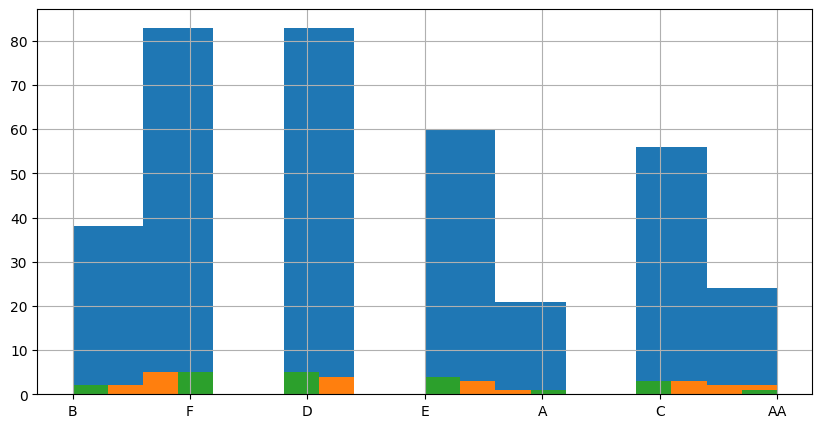

In [171]:
# del conjunto que ya procesamos haremos una división de datos de forma aleatoria - datos de entrenamientos 80% - datos de test 10% - 10% datos de validación 
# Separamos el conjunto de datos 80% train set, 20% test set - como afluenta tiene un rango de score vamos a usar para que la división aleatoria
# se realice de forma proporcional del Perfil.
import sklearn
from sklearn.model_selection import train_test_split
df_prueba
#la función principal de train test split divide en dos conjuntos por esto vamos a realizar una función que me divida en train y set y que tambien el set divida en 2 para tener set y validación
# Construcción de una función que realice el particionado completo se debe poner el fichero, proporcion para train,test,val, y la variable para el stratify
def particionador(df, rstate=42, shuffle=True, st=None):
    strat=df[st]
    train_set, test_set = train_test_split(df, test_size=0.1 , random_state=rstate, shuffle=shuffle , stratify=strat)
    
    df=test_set
    strat=df[st]
    test_set, val_set = train_test_split(df, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    
    return (train_set, val_set, test_set)
    
train_set, val_set, test_set = particionador(df=df_prueba ,rstate=42, shuffle=True, st='Perfil')   
train_set_arbol, val_set_arbol, test_set_arbol = particionador(df=df ,rstate=42, shuffle=True, st='Perfil') 
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

import matplotlib.pyplot as plt
train_set["Perfil"].hist()
test_set["Perfil"].hist()
val_set["Perfil"].hist(bins=20, figsize=(10,5))


In [172]:
#transformaremos a traves de Sklearn ->LabelEncoder de valores categóricos a numéricos (Destino-Zona Geografica-Perfil-class)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder


# Una vez que ya distribuimos según perfil podemos borrar ya que tenemos creada la dummies
train_set=train_set.drop("Perfil", axis=1)
test_set=test_set.drop("Perfil", axis=1)
val_set=val_set.drop("Perfil", axis=1)

# Conjunto de datos general
X_df = df_prueba.drop("class", axis=1)
y_df = df_prueba["class"].copy()
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train=train_set["class"].copy()
# Conjunto de datos de validación
X_val = val_set.drop("class", axis=1)
y_val = val_set["class"].copy()
# Conjunto de datos de pruebas
X_test = test_set.drop("class", axis=1)
y_test= test_set["class"].copy()


In [173]:
df_prueba['class']=df_prueba['class'].astype(int)
print(df_prueba['Perfil_A'].dtype)
print(df_prueba['class'].dtype)

y_train=(y_train).astype(int)
y_test=(y_test).astype(int)
y_val=(y_val).astype(int)
print(df_prueba.dtypes)


int32
int32
Edad                                                   int64
Perfil                                                object
Plazo                                                  int64
class                                                  int32
ingresos en dolares                                  float64
Destino_Cambio de vehiculo                             int32
Destino_Celebracion                                    int32
Destino_Compra de equipamientos                        int32
Destino_Compra de inventario o materias primas         int32
Destino_Consolidacion de deuda                         int32
Destino_Decoracion                                     int32
Destino_Educacion                                      int32
Destino_Enlace y casamiento                            int32
Destino_Gastos medicos                                 int32
Destino_Inicio actividad independiente                 int32
Destino_Inversion relacionadas a locales/oficinas      int32
Destino_Muda

In [192]:
import statsmodels.formula.api as smf    # Para regresión logística

reg_log = smf.logit(formula='Destino_Mudanza ~ Plazo', data=df_prueba).fit()
print(reg_log.summary())

Optimization terminated successfully.
         Current function value: 0.141647
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        Destino_Mudanza   No. Observations:                  406
Model:                          Logit   Df Residuals:                      404
Method:                           MLE   Df Model:                            1
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:               0.0003350
Time:                        10:59:13   Log-Likelihood:                -57.509
converged:                       True   LL-Null:                       -57.528
Covariance Type:            nonrobust   LLR p-value:                    0.8444
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.5919      0.988     -3.636      0.000      -5.528      -1.655
Plazo          0.0050      0.

In [175]:
#entrenamiento, luego de preparar los datos empezaremos a realizar los entrenamientos 
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="newton-cg", max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='newton-cg')

F1 score utilizando regresión logística con datos de validación: 0.9333333333333333
F1 score utilizando regresión logística con datos de testeo: 0.8


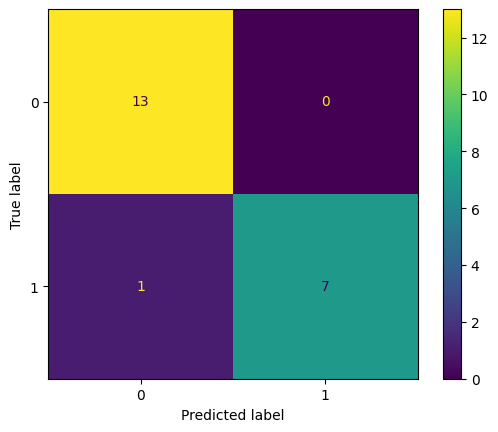

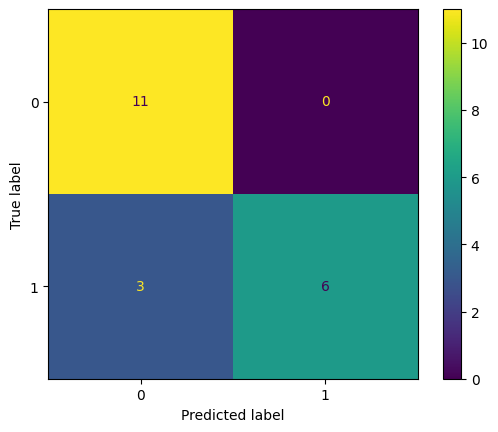

In [180]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
#Realizamos una predicción con el modelo generado anteriormente tras el entrenamiento del algoritmo de Regresión Logística. Utilizamos el subconjunto de validación.
y_pred = clf.predict(X_val)
print("F1 score utilizando regresión logística con datos de validación:", f1_score(y_val, y_pred))
confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val, values_format='d')

# Transformamos el subconjunto de datos de validación
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, values_format='d')
print("F1 score utilizando regresión logística con datos de testeo:", f1_score(y_test, y_pred))


F1 Score datos de validación utilizando gaussian kernel: 1.0
F1 Score con datos de testeo utilizando gaussian kernel: 0.8235294117647058


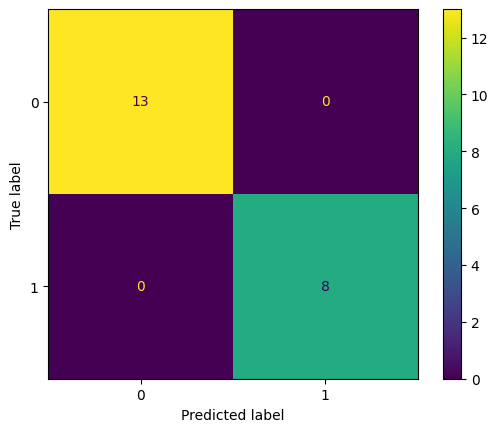

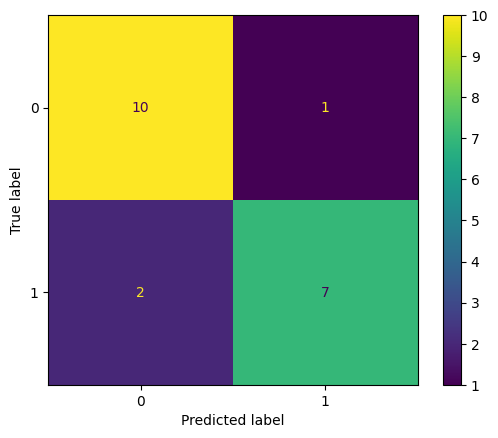

In [182]:
# Entrenamiento con metodo gaussian kernel 
from sklearn.svm import SVC

rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.00005, C=100000))
        ])
#con datos de validación
rbf_kernel_svm_clf.fit(X_train, y_train)
y_pred = rbf_kernel_svm_clf.predict(X_val)
print("F1 Score datos de validación utilizando gaussian kernel:", f1_score(y_pred, y_val))
ConfusionMatrixDisplay.from_estimator(rbf_kernel_svm_clf, X_val, y_val, values_format='d')

#con datos de testeo
y_pred_test = rbf_kernel_svm_clf.predict(X_test)
print("F1 Score con datos de testeo utilizando gaussian kernel:", f1_score(y_pred_test, y_test))
ConfusionMatrixDisplay.from_estimator(rbf_kernel_svm_clf, X_test, y_test, values_format='d')

In [201]:
#naive bayes
from sklearn.naive_bayes import BernoulliNB

nb_clf=BernoulliNB(alpha=1.0e-10)
nb_clf.fit(X_train,y_train)
y_pred=nb_clf.predict(X_test)
y_pred_val=nb_clf.predict(X_val)

In [202]:
print("F1 Score datos de test utilizando naive bayes :", f1_score(y_pred, y_test))
print("F1 Score datos de validación utilizando naive bayes :", f1_score(y_pred_val, y_val))


F1 Score datos de test utilizando naive bayes : 0.8235294117647058
F1 Score datos de validación utilizando naive bayes : 1.0
